# **Amaozon Invenotry Managment**

---

## Importing Libraies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import requests
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.util import *
from textblob import TextBlob
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

lm = WordNetLemmatizer()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [ ]:
#Loading Loading training and testing data and storing them accordingly
train_ds = "/content/drive/MyDrive/Hackathon/Amazon ML Challenge/train.csv"
test_ds = "/content/drive/MyDrive/Hackathon/Amazon ML Challenge/test.csv"
train = pd.read_csv(train_ds)
test = pd.read_csv(test_ds)

In [ ]:
train.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000


In [ ]:
test.head()

,product_id,title,bullet_points,description
0,604373,manuel dhéliogravure et de photogravure en rel...,,
1,1729783,dcgaring microfiber throw blanket warm fuzzy p...,,dcgaring throw blanket size chart w x l twin...
2,1871949,imatch auto parts front license plate bracket ...,,replacement for the following lexus lexus ...
3,1107571,pinmart gold plated excellence in service yea...,,our excellence in service lapel pins feature a...
4,624253,visual mathematics illustrated by the and the,,


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2249698 entries, 0 to 2249697
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   PRODUCT_ID       int64  
 1   TITLE            object 
 2   BULLET_POINTS    object 
 3   DESCRIPTION      object 
 4   PRODUCT_TYPE_ID  int64  
 5   PRODUCT_LENGTH   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 103.0+ MB


## Data Pre-processing

In [ ]:
train.isnull().sum()

PRODUCT_ID               0
TITLE                   12
BULLET_POINTS       837364
DESCRIPTION        1157381
PRODUCT_TYPE_ID          0
PRODUCT_LENGTH           0
dtype: int64

In [ ]:
test.isnull().sum()

PRODUCT_ID              0
TITLE                   5
BULLET_POINTS      275922
DESCRIPTION        380001
PRODUCT_TYPE_ID         0
dtype: int64

In [ ]:
train.dropna(how = 'all', axis = 1, inplace = True)
test.dropna(how = 'all', axis = 1, inplace = True)
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
train_count = train.groupby('TITLE')['TITLE'].agg('count').values
train_count

array([12,  1,  1, ...,  1,  1,  1])

In [ ]:
test_count = test.groupby('TITLE')['TITLE'].agg('count').values
test_count

array([5, 1, 1, ..., 1, 1, 1])

In [ ]:
print(train.shape)
print(test.shape)

(2249698, 6)
(734736, 5)


In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
# clean the text columns of train dataset
train['TITLE'] = train['TITLE'].apply(clean_text)
train['DESCRIPTION'] = train['DESCRIPTION'].apply(clean_text)
train['BULLET_POINTS'] = train['BULLET_POINTS'].apply(clean_text)

In [ ]:
# clean the text columns of test dataset
test['TITLE'] = test['TITLE'].apply(clean_text)
test['DESCRIPTION'] = test['DESCRIPTION'].apply(clean_text)
test['BULLET_POINTS'] = test['BULLET_POINTS'].apply(clean_text)

In [ ]:
train.describe()

,PRODUCT_ID,PRODUCT_TYPE_ID,PRODUCT_LENGTH
count,2.249698e+06,2.249698e+06,2.249698e+06
mean,1.499795e+06,4.000456e+03,4.071839e+03
std,8.661944e+05,3.966146e+03,1.351685e+06
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,7.494795e+05,2.300000e+02,5.118110e+02
50%,1.499558e+06,2.916000e+03,6.630000e+02
75%,2.250664e+06,6.403000e+03,1.062992e+03
max,2.999999e+06,1.342000e+04,1.885801e+09


In [ ]:
test.describe()

,PRODUCT_ID,PRODUCT_TYPE_ID
count,7.347360e+05,734736.000000
mean,1.493725e+06,4001.628103
std,8.669773e+05,3965.893339
min,0.000000e+00,0.000000
25%,7.396735e+05,228.000000
50%,1.492776e+06,2916.000000
75%,2.242406e+06,6396.000000
max,2.999998e+06,13420.000000


In [ ]:
train.corr()

,PRODUCT_ID,PRODUCT_TYPE_ID,PRODUCT_LENGTH
PRODUCT_ID,1.000000,0.250576,0.000424
PRODUCT_TYPE_ID,0.250576,1.000000,0.000961
PRODUCT_LENGTH,0.000424,0.000961,1.000000


## **Data Visualization**

Text(0.5, 1.0, 'Highest Number of Products based on Product Length')

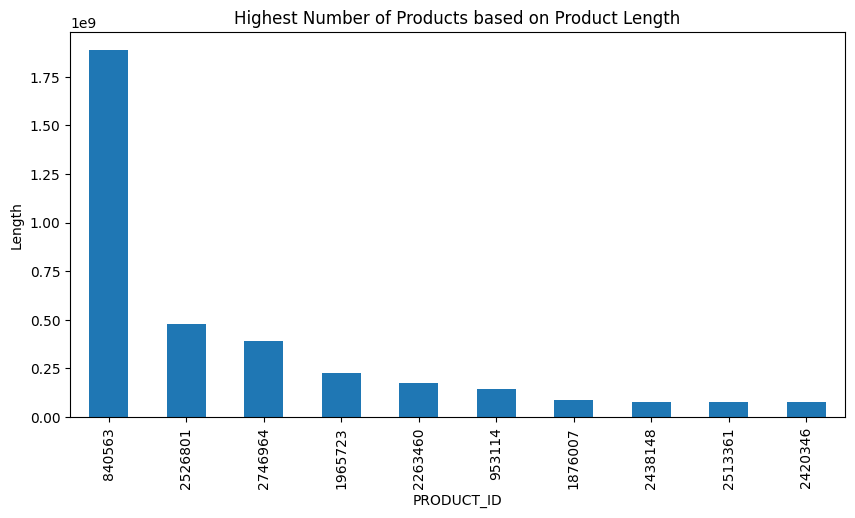

In [ ]:
plt.figure(figsize=(10,5))
train.groupby(['PRODUCT_ID'])['PRODUCT_LENGTH'].mean().sort_values(ascending = False).head(10).plot.bar()
plt.ylabel('Length')
plt.title('Highest Number of Products based on Product Length')

<Axes: >

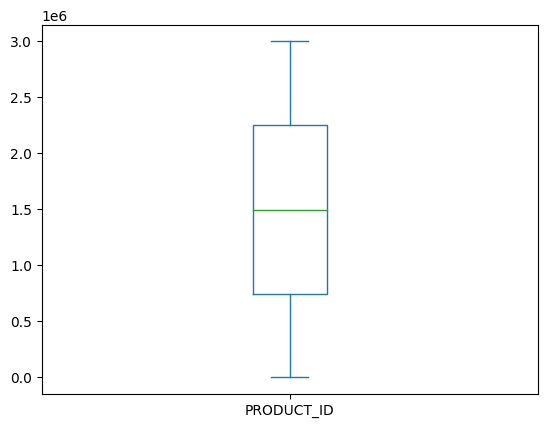

In [ ]:
train.PRODUCT_ID.plot.box()

<Axes: xlabel='PRODUCT_LENGTH'>

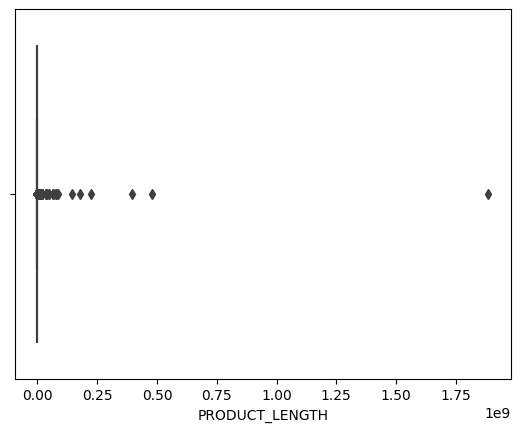

In [ ]:
sns.boxplot(x = 'PRODUCT_LENGTH', data=train)

In [ ]:
sns.displot(train.PRODUCT_LENGTH)

<Axes: >

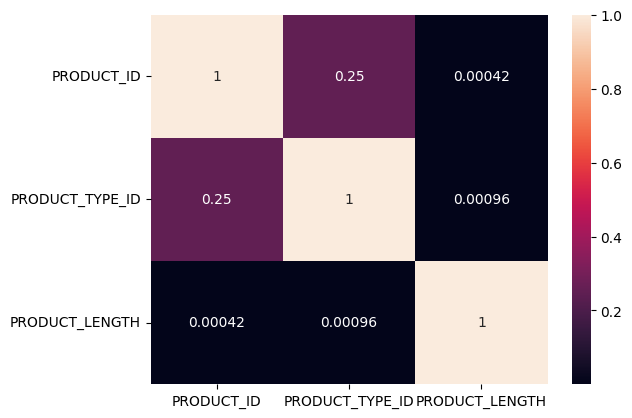

In [ ]:
sns.heatmap(train.corr(),annot=True)

In [ ]:
sns.jointplot(x='PRODUCT_ID', y='PRODUCT_LENGTH', data = train, kind='reg')

In [ ]:
# drop the 'PRODUCT_TYPE_ID' column
train.drop('PRODUCT_TYPE_ID', axis=1, inplace=True)
test.drop('PRODUCT_TYPE_ID', axis=1, inplace=True)

In [ ]:
# rename the columns to lowercase
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [ ]:
print(train.dtypes)
print(test.dtypes)

product_id          int64
title              object
bullet_points      object
description        object
product_length    float64
dtype: object
product_id        int64
title            object
bullet_points    object
description      object
dtype: object


In [ ]:
# saving the preprocessed data to a new csv file
train.to_csv('preprocessed_train.csv', index=False)
test.to_csv('preprocessed_test.csv', index=False)

# **Data Analysis**

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
# Loading data
preprocessed_train = pd.read_csv("preprocessed_train.csv")
preprocessed_test = pd.read_csv("preprocessed_test.csv")

In [ ]:
#Converting the object data to numeric data for traing set
preprocessed_train['title'] = pd.to_numeric(preprocessed_train['title'], errors='coerce')
preprocessed_train['bullet_points'] = pd.to_numeric(preprocessed_train['bullet_points'], errors='coerce')
preprocessed_train['description'] = pd.to_numeric(preprocessed_train['description'], errors='coerce')
preprocessed_train.fillna(0, inplace=True)

In [ ]:
#Converting the onject data to numeric data for testing set
preprocessed_test['title'] = pd.to_numeric(preprocessed_test['title'], errors='coerce')
preprocessed_test['bullet_points'] = pd.to_numeric(preprocessed_test['bullet_points'], errors='coerce')
preprocessed_test['description'] = pd.to_numeric(preprocessed_test['description'], errors='coerce')
preprocessed_test.fillna(0, inplace=True)

In [ ]:
print(preprocessed_train.dtypes)
print(preprocessed_test.dtypes)

product_id          int64
title             float64
bullet_points     float64
description       float64
product_length    float64
dtype: object
product_id         int64
title            float64
bullet_points    float64
description      float64
dtype: object


In [ ]:
# replace infinite values with NaN
preprocessed_train[preprocessed_train == np.inf] = np.nan
preprocessed_train[preprocessed_train == -np.inf] = np.nan
preprocessed_test[preprocessed_test == np.inf] = np.nan
preprocessed_test[preprocessed_test == -np.inf] = np.nan

# replace values too large for float64 with NaN
preprocessed_train[np.abs(preprocessed_train) > np.finfo(np.float64).max] = np.nan
preprocessed_test[np.abs(preprocessed_test) > np.finfo(np.float64).max] = np.nan

In [ ]:
print(preprocessed_train.isnull().sum())
print(preprocessed_test.isnull().sum())

product_id        0
title             4
bullet_points     0
description       0
product_length    0
dtype: int64
product_id       0
title            2
bullet_points    0
description      0
dtype: int64


In [ ]:
preprocessed_train['title'].fillna(0.0, inplace = True)
preprocessed_test['title'].fillna(0.0, inplace = True)

In [ ]:
preprocessed_train.describe()

,product_id,title,bullet_points,description,product_length
count,2.249698e+06,2249698.0,2249698.0,2249698.0,2.249698e+06
mean,1.499795e+06,0.0,0.0,0.0,4.071839e+03
std,8.661944e+05,0.0,0.0,0.0,1.351685e+06
min,1.000000e+00,0.0,0.0,0.0,1.000000e+00
25%,7.494795e+05,0.0,0.0,0.0,5.118110e+02
50%,1.499558e+06,0.0,0.0,0.0,6.630000e+02
75%,2.250664e+06,0.0,0.0,0.0,1.062992e+03
max,2.999999e+06,0.0,0.0,0.0,1.885801e+09


In [ ]:
preprocessed_test.describe()

,product_id,title,bullet_points,description
count,7.347360e+05,734736.0,734736.0,734736.0
mean,1.493725e+06,0.0,0.0,0.0
std,8.669773e+05,0.0,0.0,0.0
min,0.000000e+00,0.0,0.0,0.0
25%,7.396735e+05,0.0,0.0,0.0
50%,1.492776e+06,0.0,0.0,0.0
75%,2.242406e+06,0.0,0.0,0.0
max,2.999998e+06,0.0,0.0,0.0


In [ ]:
preprocessed_train.drop('product_length', axis=1, inplace=True)

In [ ]:
# Preprocess the training data
X_train = preprocessed_train.drop(['product_id'], axis=1)
y_train = preprocessed_train['product_id']

In [ ]:
# Preprocess the training data
X_test = preprocessed_test.drop(['product_id'], axis=1)
y_test = preprocessed_test['product_id']

In [ ]:
#Training and Evaluation of Data

models = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared Score: {r2}")
    print("\n")

Model: LinearRegression
Mean Absolute Error (MAE): 751194.9711177737
Mean Squared Error (MSE): 751685396633.82
Root Mean Squared Error (RMSE): 866997.9219316618
R-squared Score: -4.90300442459457e-05


Model: DecisionTreeRegressor
Mean Absolute Error (MAE): 751194.9711177737
Mean Squared Error (MSE): 751685396633.82
Root Mean Squared Error (RMSE): 866997.9219316618
R-squared Score: -4.90300442459457e-05


